In [1]:
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size,
                            num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    # refrence: https://github.com/kohyar/LTTng_LSTM_Anomaly_Detection
    def forward(self, x, sequence_length, input_size):
        assert x.shape == (x.shape[0], sequence_length, input_size)
        h0 = torch.zeros(self.num_layers, x.size(0),
                         self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0),
                         self.hidden_size).to(device)

        lstm_out, _ = self.lstm(x, (h0, c0))

        out = self.fc(lstm_out[:, -1, :])

        return out


def train_model(model, train_loader, epochs, optimizer, loss_function, sequence_length, input_size,val_loader, verbose=False,save_model=False):
    model.train()
    losses = []
    for epoch in range(epochs):
        epoch_losses = []
        for i, (x, y) in enumerate(train_loader):
            x, y = x.to(device), y.to(device)
            model.zero_grad()
            output = model(x, sequence_length, input_size)
            loss = loss_function(output, y)
            epoch_losses.append(loss.item())
            loss.backward()
            optimizer.step()
            if verbose and i % (train_loader.batch_size*10) == 0:
                print(
                    f'Epoch {epoch} Batch {i//train_loader.batch_size} loss: {loss.item()}')
        print(f'Epoch {epoch} loss: {np.mean(epoch_losses)}, val_loss: {validate(model, val_loader)}')
        losses.append(epoch_losses)
    if save_model:
        torch.save(model.state_dict(), 'fnn_trained_model.pth')
    return losses

def validate(network, val_loader):
    losses = []
    with torch.no_grad():
        for batch in val_loader:
            features, labels = batch
            network.eval()
            o = network(features, features.shape[1], features.shape[2])
            loss = torch.nn.functional.mse_loss(o, labels)
            losses.append(loss.item())
    losses = np.array(losses)
    losses = losses[~np.isnan(losses)]
    return np.mean(losses)


In [2]:
from load_data import getTrainingSet, getValidationSet
from config import *
dataset = getTrainingSet(reshape=True)
val_set = getValidationSet()
input_size = len(dataset.X[0][0])
sequence_length = len(dataset.X[0])
hidden_size = SIZE_OF_HIDDEN_LAYER_LSTM
num_layers = NUM_LAYERS_LSTM
output_size = OUTPUT_SIZE
learning_rate = LEARNING_RATE
batch_size = BATCH_SIZE
epochs = EPOCHS_LSTM

print(f'input_size: {input_size}, sequence_length: {sequence_length}')

model = LSTM(input_size, hidden_size, num_layers, output_size)
loss_function = nn.MSELoss()
adam = optim.Adam(model.parameters(), learning_rate)
train_dataloader = DataLoader(dataset, batch_size, shuffle=True)

losses = train_model(
    model,
    train_dataloader,
    epochs,
    adam,
    loss_function,
    sequence_length,
    input_size,
    val_loader=DataLoader(val_set, batch_size, shuffle=True),
    save_model=True
)

# train(model, dataset, batch_size, epochs)

   year  month  day  hour  NO1_temperature  consumption_t-1  NO1_consumption
1  2017      5    1     1              1.8      3325.431995      3344.690998
2  2017      5    1     2              3.2      3344.690998      3398.359002
3  2017      5    1     3              3.6      3398.359002      3430.220001
4  2017      5    1     4              3.4      3430.220001      3606.750000
5  2017      5    1     5              3.1      3606.750000      3739.876998
Train set shape: (35077, 6) (35077,)
Validation set shape: (11693, 6) (11693,)
Test set shape: (11693, 6) (11693,)
input_size: 6, sequence_length: 24


C:\Users\Jonah\AppData\Local\Temp\ipykernel_11804\3975461612.py:59: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = torch.nn.functional.mse_loss(o, labels)
C:\Users\Jonah\AppData\Local\Temp\ipykernel_11804\3975461612.py:59: UserWarning: Using a target size (torch.Size([22])) that is different to the input size (torch.Size([22, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = torch.nn.functional.mse_loss(o, labels)


Epoch 0 loss: 0.03021296780292169, val_loss: 1.7946505698439192
Epoch 1 loss: 0.003774090295682583, val_loss: 1.8403321063681826
Epoch 2 loss: 0.001972433123746071, val_loss: 1.8450452863353572
Epoch 3 loss: 0.0015331935384467986, val_loss: 1.8446533601577968
Epoch 4 loss: 0.0014026414401817346, val_loss: 1.8428200084869175
Epoch 5 loss: 0.0013230492296468477, val_loss: 1.8375672017058282
Epoch 6 loss: 0.0011925906463572712, val_loss: 1.8456468394357863
Epoch 7 loss: 0.001142201576050308, val_loss: 1.8266938866001285
Epoch 8 loss: 0.001073419764369427, val_loss: 1.8402303689146695
Epoch 9 loss: 0.001005480418055672, val_loss: 1.8466788894509616


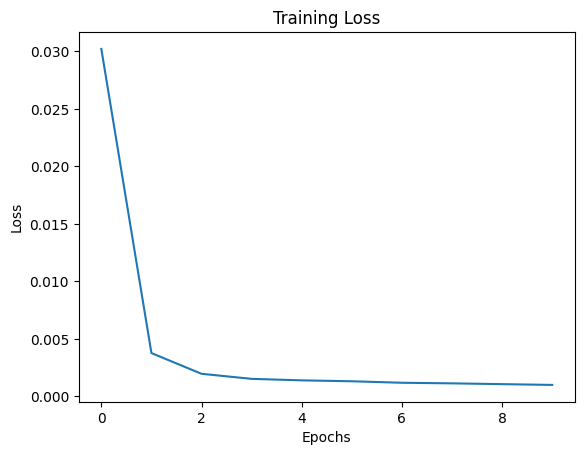

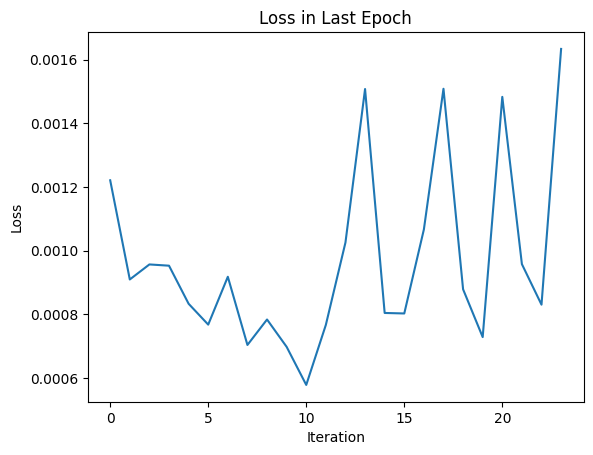

In [3]:
import matplotlib.pyplot as plt

plt.plot([sum(epoch_losses)/len(epoch_losses) for epoch_losses in losses])
# new_epochs = range(0, len(losses), len(losses)//epochs)
# for epoch in new_epochs:
#     plt.axvline(x=epoch, color='r', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

plt.plot(losses[-1][:24])
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss in Last Epoch')
plt.show()
